In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

from functions_air_quality_madrid import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Air quality Madrid - Pipeline

In [4]:
# Import full dataframe

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

particles_of_interest = ['NO_2', 'O_3', 'PM10', 'SO_2']

df_full['all_particles'] = df_full[particles_of_interest].sum(axis=1)

# Select data for the time period, particles and stations of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

particle_of_interest = 'all_particles'
stations_of_interest = [28079008, 28079018, 28079024]

df_temp = df_full.loc[first_date:last_date][[particle_of_interest, 'station']].sort_index()
df_temp = df_temp.loc[df_temp['station'].isin(stations_of_interest)]
df_temp['quarter'] = df_temp.index.quarter
df_temp['dayofyear'] = df_temp.index.dayofyear
df_temp['dayofmonth'] = df_temp.index.day
df_temp['weekyear'] = df_temp.index.weekofyear
df_temp['weekday'] = df_temp.index.weekday
df_temp['hour'] = df_temp.index.hour
df_temp['year'] = df_temp.index.year
df_temp['month'] = df_temp.index.month
df_temp.fillna(0, inplace=True)

print(f'The time period is from {first_date} to {last_date}')
print('')
print(f'The particle of interest is: {particle_of_interest}')
print('')
print(f'One particle DF shape: {df_temp.shape}')

df_temp.head()

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

The particle of interest is: all_particles

One particle DF shape: (166464, 10)


,all_particles,station,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,,
2012-01-01 00:00:00,181.0,28079008,1,1,1,52,6,0,2012,1
2012-01-01 00:00:00,88.0,28079024,1,1,1,52,6,0,2012,1
2012-01-01 00:00:00,150.0,28079018,1,1,1,52,6,0,2012,1
2012-01-01 01:00:00,107.0,28079018,1,1,1,52,6,1,2012,1
2012-01-01 01:00:00,71.0,28079024,1,1,1,52,6,1,2012,1


## EDA and stationarity analysis for the target variable

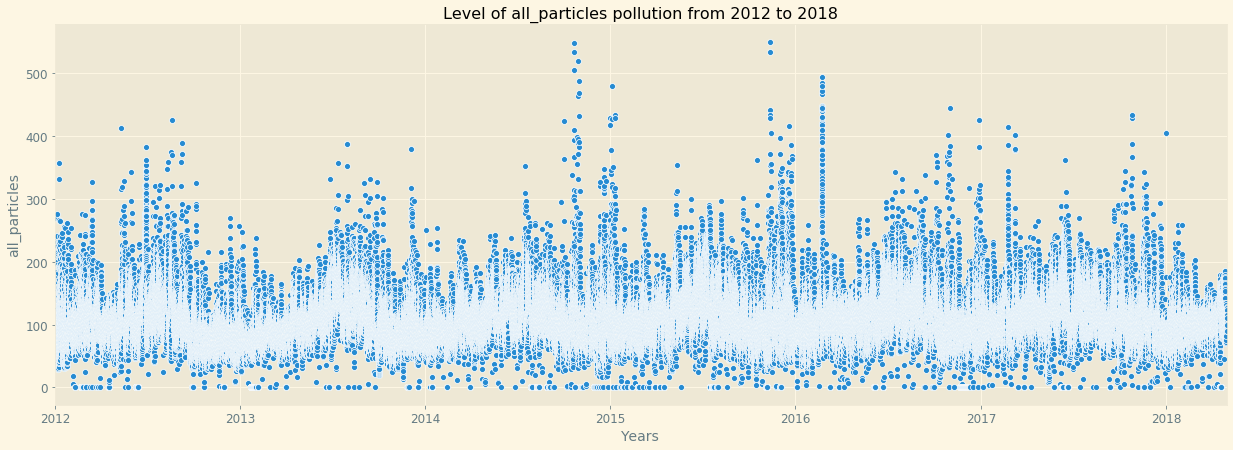

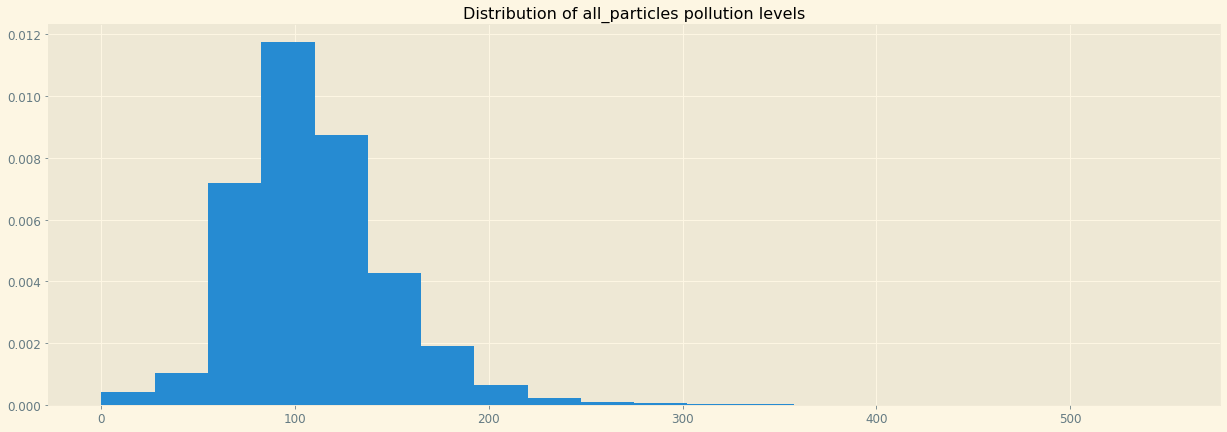

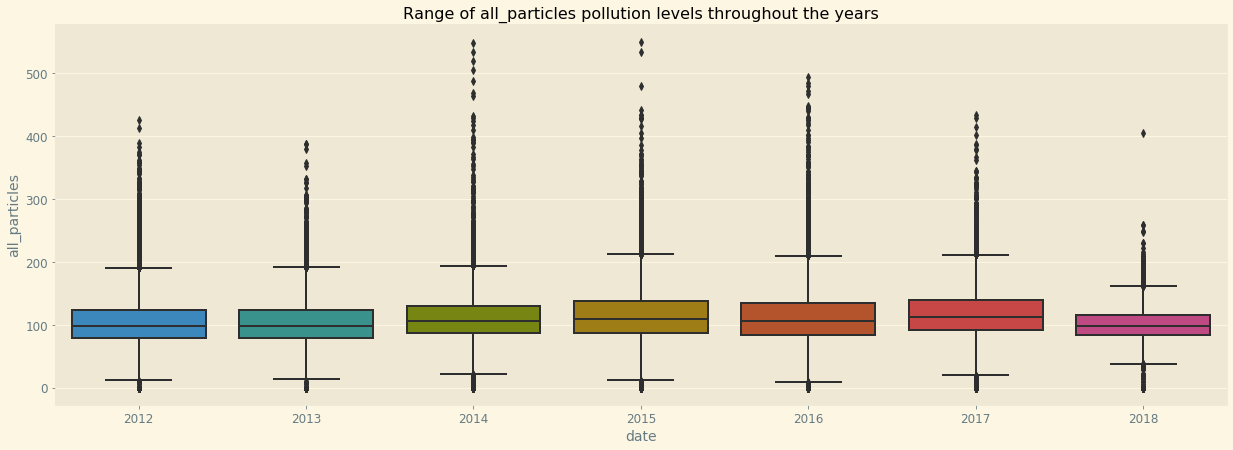

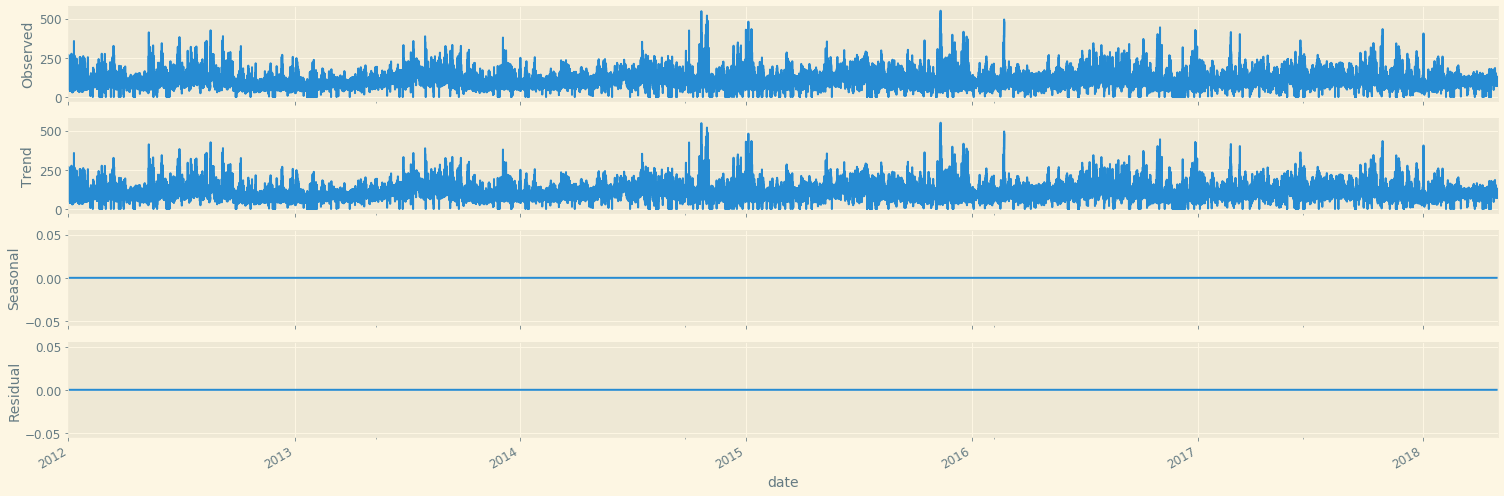

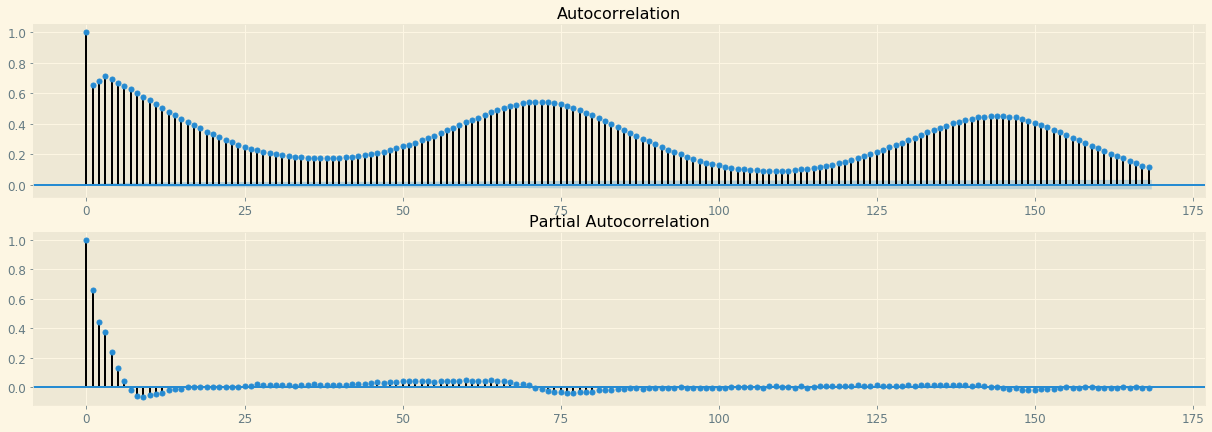

Stationarity Tests:
Original target:
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic                -1.568312e+01
p-value                        1.464412e-28
#Lags Used                     7.700000e+01
Number of Observations Used    1.663860e+05
Critical Value 1%             -3.430389e+00
Critical Value 5%             -2.861557e+00
Critical Value 10%            -2.566779e+00
dtype: float64 

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic          5.715149
p-value                 0.010000
Lags Used              77.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64 



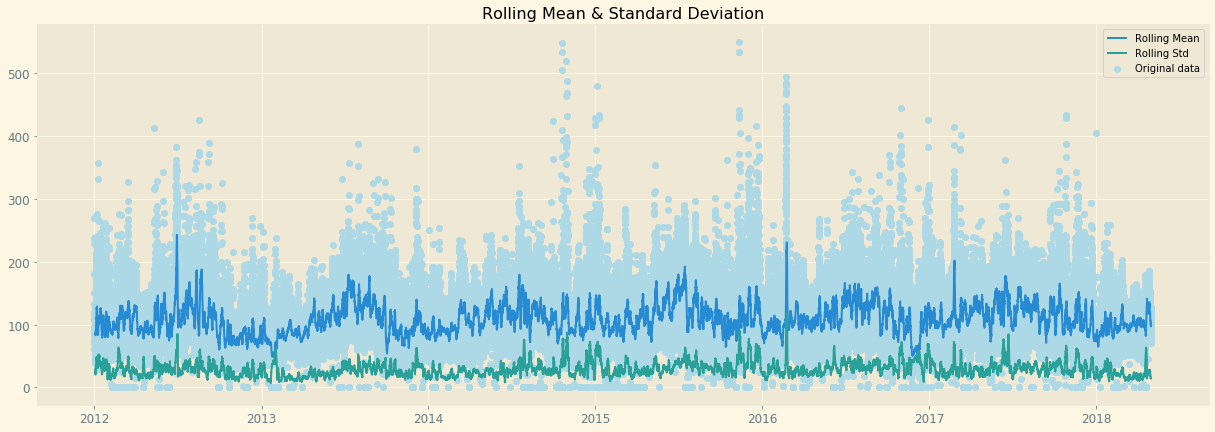

In [5]:
# Plot target variable

fig, ax = plt.subplots(figsize=(21,7))
sns.scatterplot(x = df_temp.index, y = df_temp[particle_of_interest])
ax.axes.set_xlim(df_temp.index.min(), df_temp.index.max())
plt.title(f'Level of {particle_of_interest} pollution from 2012 to 2018') 
plt.xlabel('Years')
plt.ylabel(particle_of_interest)

# Plot the distribution target variable

fig, ax = plt.subplots(figsize=(21,7))
df_temp[particle_of_interest].hist(density=True, bins = 20)
plt.title(f'Distribution of {particle_of_interest} pollution levels') 

# Plot the range and year on year variability of the target variable 

fig, ax = plt.subplots(figsize=(21,7))
sns.boxplot(df_temp.index.year, df_temp[particle_of_interest])
plt.title(f'Range of {particle_of_interest} pollution levels throughout the years') 

# Plot the decomposition of the target variable with an additive model

from pylab import rcParams
rcParams['figure.figsize'] = 21, 7
decomposition = seasonal_decompose(df_temp[particle_of_interest], model='additive', freq=1)
fig = decomposition.plot()
plt.show()

# Plot the autocorrelation and partial autocorrelation functions for the target variable

plt.figure(figsize=(21,7))
plt.subplot(211)
plot_acf(df_temp[particle_of_interest], ax=plt.gca(), lags = 24*7)
plt.subplot(212)
plot_pacf(df_temp[particle_of_interest], ax=plt.gca(), lags = 24*7)
plt.show()

# Apply stationarity tests to the original target variable

print('Stationarity Tests:')
print('Original target:')
adf_test(df_temp[particle_of_interest])
kpss_test(df_temp[particle_of_interest])
plot_rolling_statistics(df_temp[particle_of_interest])

### Station nr 28079008 - Parque del Retiro/ Escuelas Aguirre

The station of interest is: 28079008

Missing values for particle and station of interest: 0.0%

One particle, one station DF shape: (55488, 9)

Rolling Averages DF shape: (55488, 9)

Shifts DF shape: (55488, 10)

All features DF shape:(55488, 28)

2018-01-07 00:00:00
[17:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:13] WARNING: src/objective/r

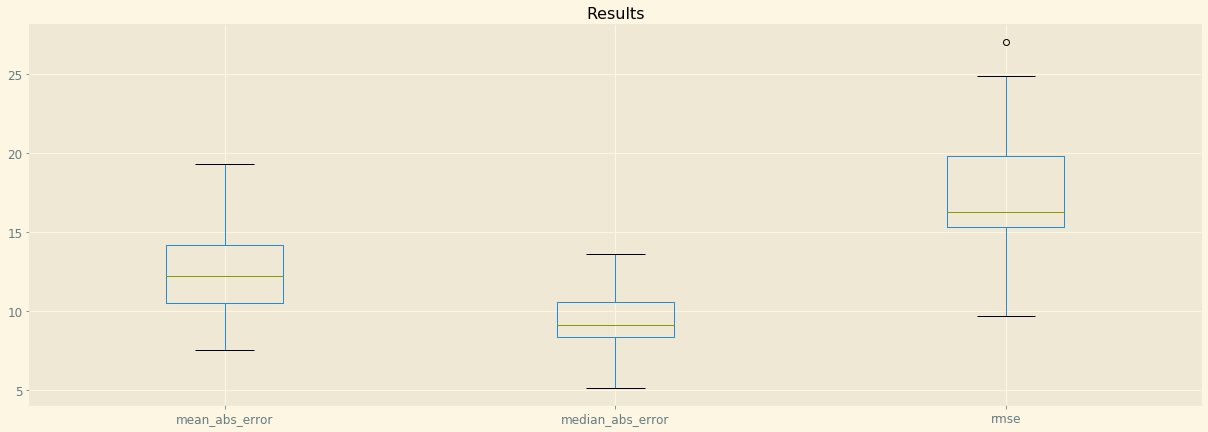

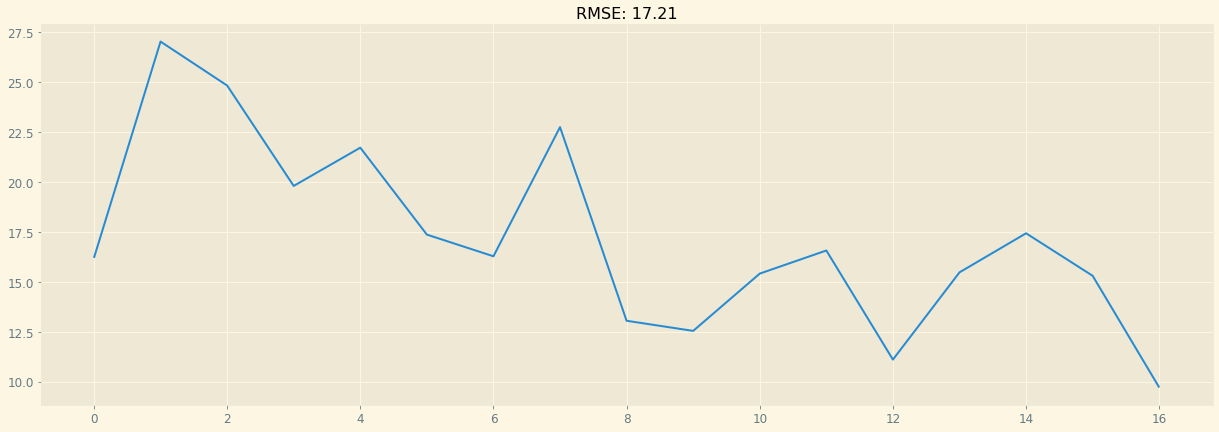

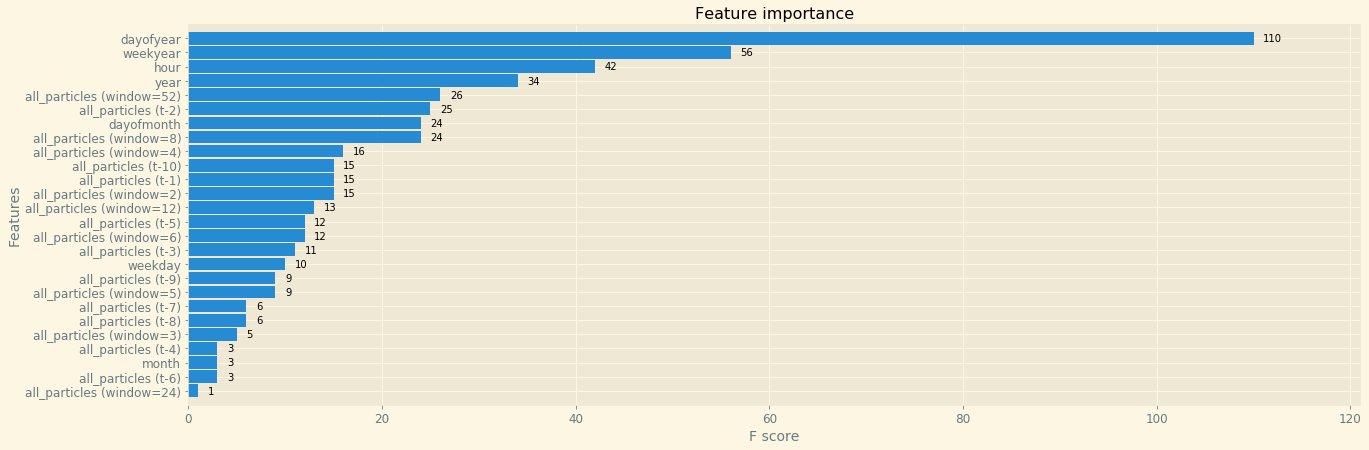

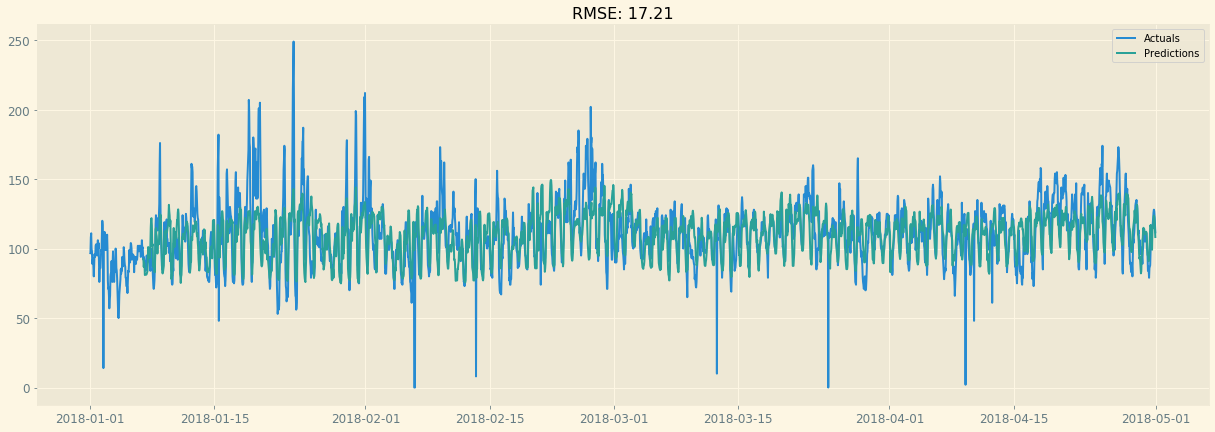

In [4]:
# Generate dataframe for one particle and one station of interest

station_of_interest = 28079008

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')

oneparticle_onestation.dropna(inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
print('')

# Create dataframes with rolling averages and shifts features

windows = [2, 3, 4, 5, 6, 8, 12, 24, 52]

rolling_averages_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(rolling_averages, particle_of_interest, windows)
print(f'Rolling Averages DF shape: {rolling_averages_groupby_df.shape}')
print('')

shifts_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(series_to_supervised, particle_of_interest, lags = 10)
print(f'Shifts DF shape: {shifts_groupby_df.shape}')
print('')

# Select features and create final dataframe

features = ['hour', 'weekday', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekyear']
rolling_features = list(rolling_averages_groupby_df.columns)
shifts_features = list(shifts_groupby_df.columns)
all_columns = [particle_of_interest] + features + rolling_features + shifts_features

# Create new dataframe with all features from groupby

all_features_df = pd.concat([oneparticle_onestation.sort_index(), shifts_groupby_df.sort_index(), rolling_averages_groupby_df.sort_index()], axis=1)
all_features_df = all_features_df[all_columns]
print(f'All features DF shape:{all_features_df.shape}')
print('')

# Generate rolling predictions and results for particle of interest

data = all_features_df.sort_index().copy()
target = particle_of_interest
all_features = [x for x in all_columns if x is not target]

fit_func = fit_XGB
predict_func = predict_XGB

min_train_date = '2018-01-01'
week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    model = fit_func(train_set, test_set, all_features, target)
    predictions = predict_func(model, test_set, all_features)
    predictions = pd.Series(predictions, index=test_set.index)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_08 = pd.DataFrame(results_over_time)
predictions_over_time_08 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_08

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot feature importances

fig, ax = plt.subplots(figsize=(21,7))
feature_importance = plot_importance(model, height=0.9, ax=ax)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

### Station nr 28079018  - San Isidro/Calle Farolillo

The station of interest is: 28079018

Missing values for particle and station of interest: 0.0%

One particle, one station DF shape: (55488, 9)

Rolling Averages DF shape: (55488, 9)

Shifts DF shape: (55488, 10)

All features DF shape:(55488, 28)

2018-01-07 00:00:00
[17:53:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:07] WARNING: src/objective/r

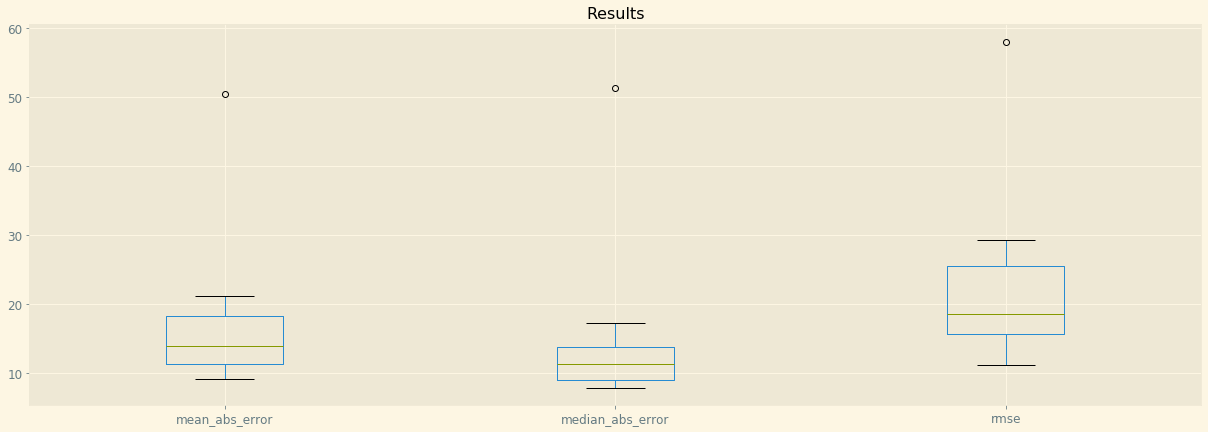

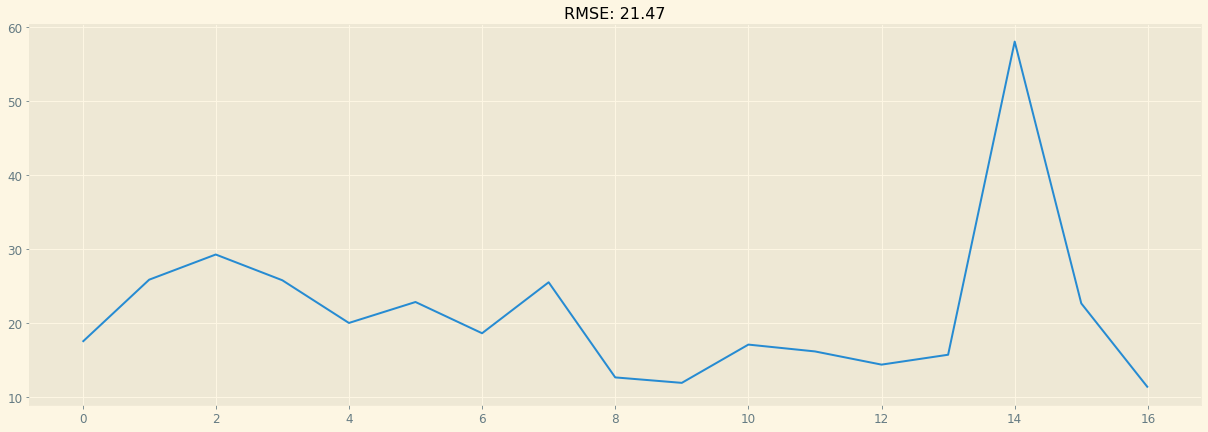

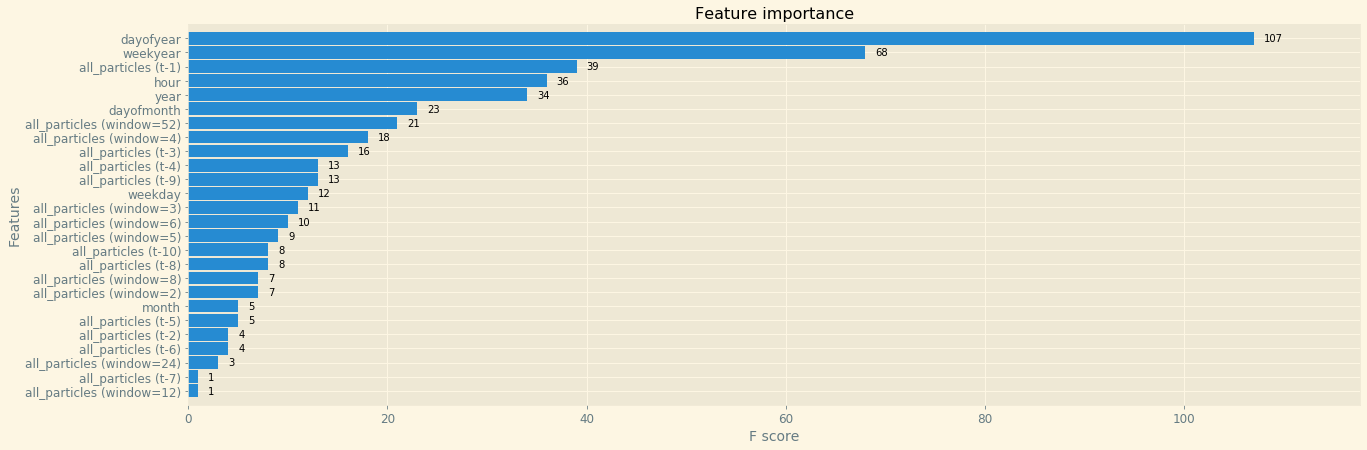

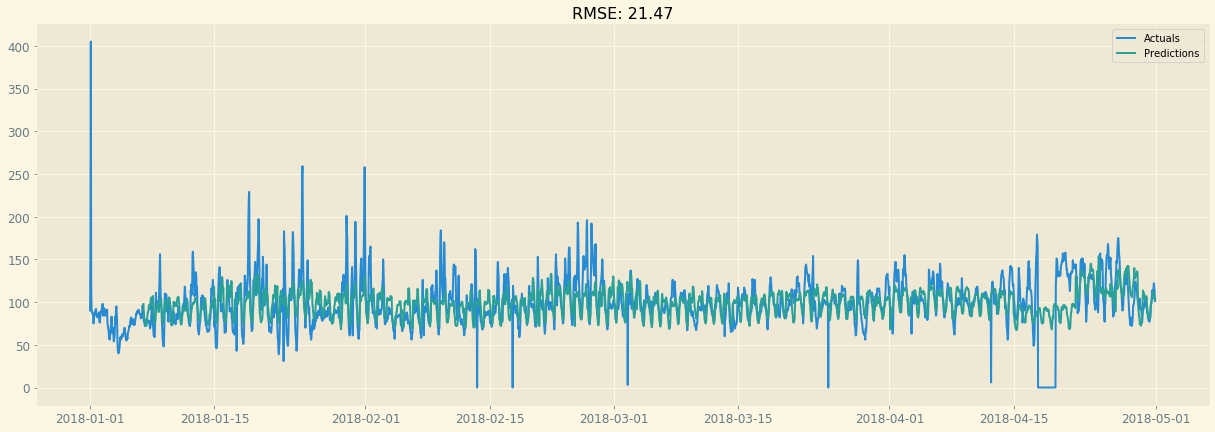

In [5]:
# Generate dataframe for one particle and one station of interest

station_of_interest = 28079018

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')

oneparticle_onestation.dropna(inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
print('')

# Create dataframes with rolling averages and shifts features

windows = [2, 3, 4, 5, 6, 8, 12, 24, 52]

rolling_averages_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(rolling_averages, particle_of_interest, windows)
print(f'Rolling Averages DF shape: {rolling_averages_groupby_df.shape}')
print('')

shifts_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(series_to_supervised, particle_of_interest, lags = 10)
print(f'Shifts DF shape: {shifts_groupby_df.shape}')
print('')

# Select features and create final dataframe

features = ['hour', 'weekday', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekyear']
rolling_features = list(rolling_averages_groupby_df.columns)
shifts_features = list(shifts_groupby_df.columns)
all_columns = [particle_of_interest] + features + rolling_features + shifts_features

# Create new dataframe with all features from groupby

all_features_df = pd.concat([oneparticle_onestation.sort_index(), shifts_groupby_df.sort_index(), rolling_averages_groupby_df.sort_index()], axis=1)
all_features_df = all_features_df[all_columns]
print(f'All features DF shape:{all_features_df.shape}')
print('')

# Generate rolling predictions and results for particle of interest

data = all_features_df.sort_index().copy()
target = particle_of_interest
all_features = [x for x in all_columns if x is not target]

fit_func = fit_XGB
predict_func = predict_XGB

min_train_date = '2018-01-01'
week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    model = fit_func(train_set, test_set, all_features, target)
    predictions = predict_func(model, test_set, all_features)
    predictions = pd.Series(predictions, index=test_set.index)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_18 = pd.DataFrame(results_over_time)
predictions_over_time_18 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_18

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot feature importances

fig, ax = plt.subplots(figsize=(21,7))
feature_importance = plot_importance(model, height=0.9, ax=ax)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time_18, results_over_time_18)

### Station nr 28079024 - Casa de Campo

The station of interest is: 28079024

Missing values for particle and station of interest: 0.0%

One particle, one station DF shape: (55488, 9)

Rolling Averages DF shape: (55488, 9)

Shifts DF shape: (55488, 10)

All features DF shape:(55488, 28)

2018-01-07 00:00:00
[17:56:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:58:05] WARNING: src/objective/r

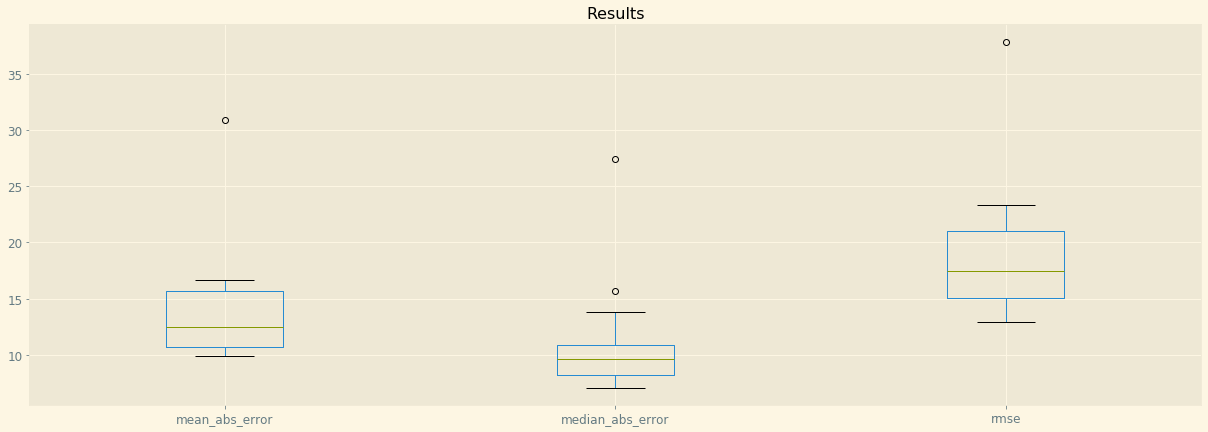

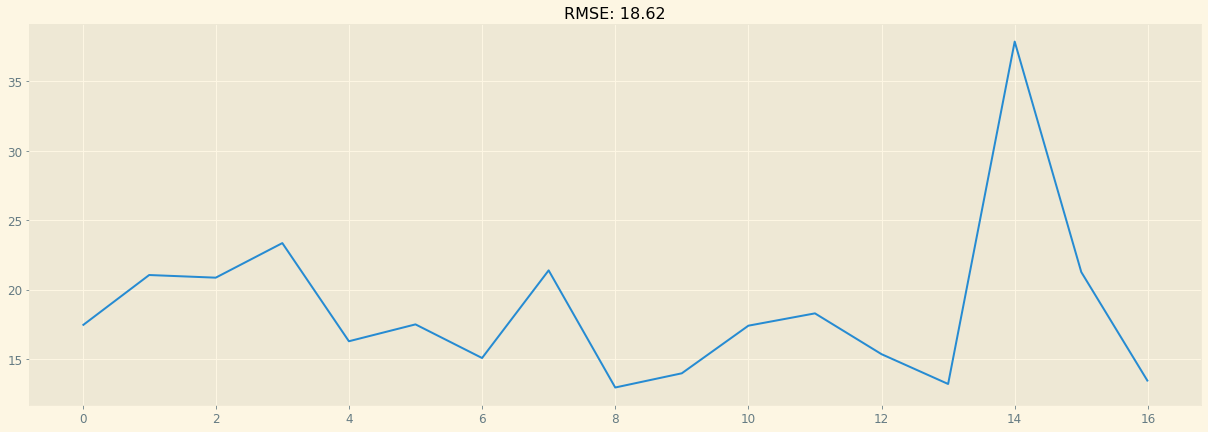

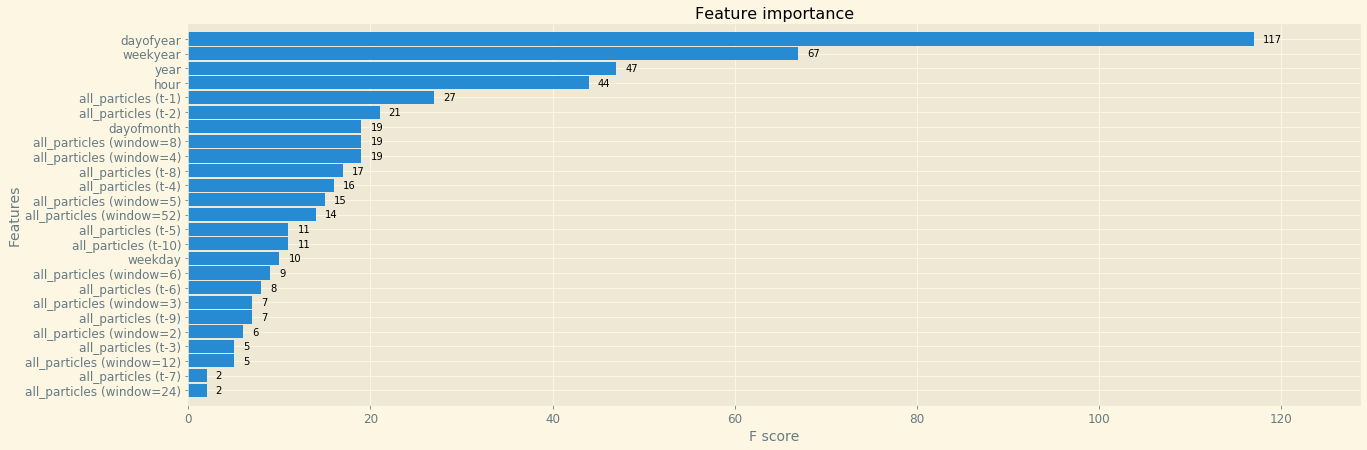

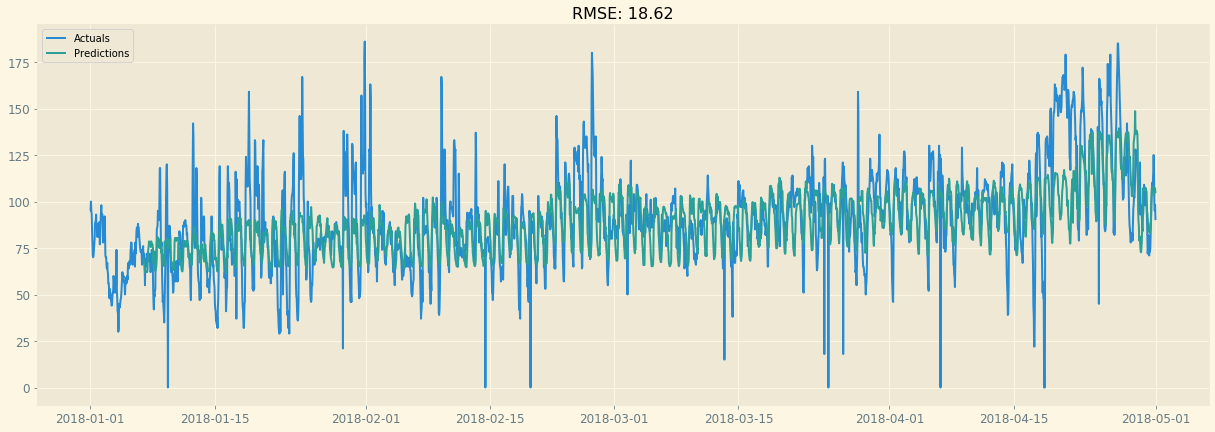

In [6]:
# Generate dataframe for one particle and one station of interest

station_of_interest = 28079024

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')

oneparticle_onestation.dropna(inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
print('')

# Create dataframes with rolling averages and shifts features

windows = [2, 3, 4, 5, 6, 8, 12, 24, 52]

rolling_averages_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(rolling_averages, particle_of_interest, windows)
print(f'Rolling Averages DF shape: {rolling_averages_groupby_df.shape}')
print('')

shifts_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(series_to_supervised, particle_of_interest, lags = 10)
print(f'Shifts DF shape: {shifts_groupby_df.shape}')
print('')

# Select features and create final dataframe

features = ['hour', 'weekday', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekyear']
rolling_features = list(rolling_averages_groupby_df.columns)
shifts_features = list(shifts_groupby_df.columns)
all_columns = [particle_of_interest] + features + rolling_features + shifts_features

# Create new dataframe with all features from groupby

all_features_df = pd.concat([oneparticle_onestation.sort_index(), shifts_groupby_df.sort_index(), rolling_averages_groupby_df.sort_index()], axis=1)
all_features_df = all_features_df[all_columns]
print(f'All features DF shape:{all_features_df.shape}')
print('')

# Generate rolling predictions and results for particle of interest

data = all_features_df.sort_index().copy()
target = particle_of_interest
all_features = [x for x in all_columns if x is not target]

fit_func = fit_XGB
predict_func = predict_XGB

min_train_date = '2018-01-01'
week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    model = fit_func(train_set, test_set, all_features, target)
    predictions = predict_func(model, test_set, all_features)
    predictions = pd.Series(predictions, index=test_set.index)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_35 = pd.DataFrame(results_over_time)
predictions_over_time_35 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_35

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot feature importances

fig, ax = plt.subplots(figsize=(21,7))
feature_importance = plot_importance(model, height=0.9, ax=ax)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time_35, results_over_time_35)

###  City average

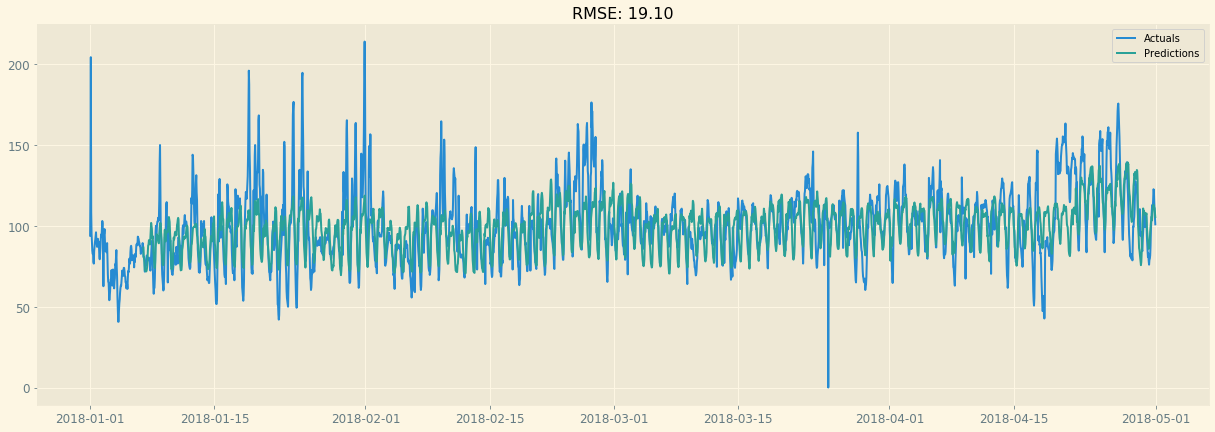

In [7]:
predictions_list =[predictions_over_time_08, predictions_over_time_18, predictions_over_time_35]
results_list = [results_over_time_08['rmse'], results_over_time_18['rmse'], results_over_time_35['rmse']]

predictions_final = pd.concat(predictions_list, axis=1).sort_index().mean(axis=1)
results_final = pd.concat(results_list, axis=1).sort_index().mean(axis=1)

target_mean = df_temp[particle_of_interest].groupby('date').mean()

fig, ax = plt.subplots(figsize=(21,7))
actuals = plt.plot(target_mean[min_train_date:], label='Actuals')
predictions = plt.plot(predictions_final, label='Predictions')
error = results_final.mean()
plt.legend(loc='best')
plt.title('RMSE: %.2f'% error)
plt.show()